# Produce IRF from test MC DL2 (all-sky MC production) with `lstchain_create_irf_files`

Create instrument response functions (IRF) in FITS format, from **test MC DL2** files assuming certain **selection cuts and event filtering** using the `lstchain_create_irf_files` Tool.

Its usage and input arguments are described in the `--help` docstring (`--help-all` for a more detailed description of all the input arguments):
```
$ lstchain_create_irf_files --help
```

This notebook explains how to produce a **[point-like IRF](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/point_like/index.html)** needed to perform a 1D analysis with Gammapy, from gamma-ray *testing* MC DL2 files.

As a reminder, here is the overall view of the MC products from [**lstmcpipe**](https://cta-observatory.github.io/lstmcpipe/pipeline.html). The standard DL1/DL2 MC files are separated as *testing* and *training* files, where the DL1 *training* files are used to train the Random Forest models for the reconstruction of DL1 files to DL2, and DL2 *testing* files are used for producing the IRFs, which, together with the gamma-ray-like selected event list, comprise the DL3, the science-ready data products.

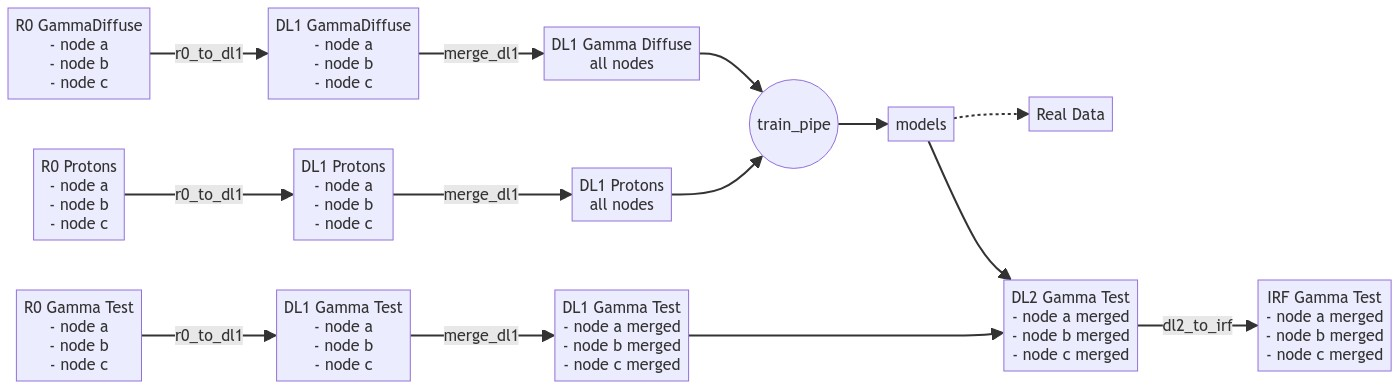


The training/testing MC samples are produced in discrete sky-pointing directions across the whole sky:
 - Training MC pointing nodes (circle markers) are produced along several declination lines.
 - Testing MC nodes are produced in a regular triangular grid in cos(zenith angle) and B⊥/B (star markers).

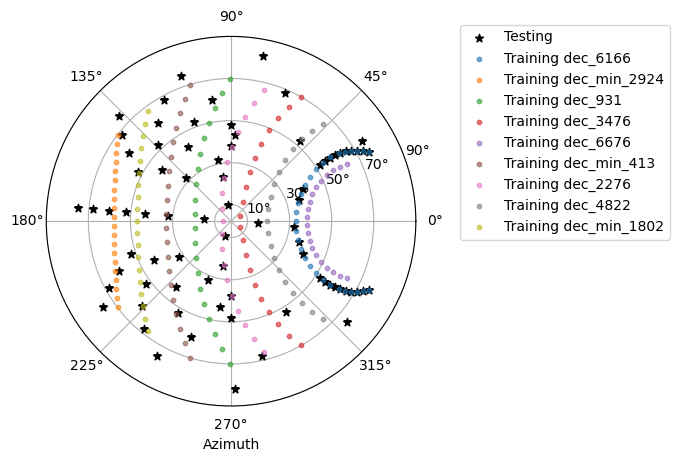

In this notebook, we calculate the IRF for each of these testing MC nodes. Then, **for any telescope pointing, the IRFs are interpolated**, a step that is done later by the `lstchain_create_dl3_file` Tool.

For the **selection of the gamma-like events** that are going to be used for the IRF calculation, there is a first selection based on certain filters (e.g. minimum intensity value), and later a set of selection cuts on *gammaness* and *theta*/*alpha*, which can be either fixed global cuts or energy-dependent cuts with a certain gamma-ray efficiency and containment region. **Important:** The same selection cuts should be used for the DL3 gamma-like event list production.

For the use of the Tool, we also need a **config file providing the event selection cuts and binning information**. One can use the example config file available in `cta-lstchain/docs/examples/irf_tool_config.json` or create a similar config file for each specific use case. If the config file is not provided, the default values are used as per the Component in the file `cta-lstchain/lstchain/io/event_selection.py`.

**Warning:** The production of *[full-enclosure IRF](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/full_enclosure/index.html#full-enclosure-irfs)* is also possible with this tool but we need diffuse gamma-ray MC DL2 (not being generated currently in the all-sky MC standard production). Also, background IRF may be calculated if proton and electron MC are provided (see last part of the notebook).

In [56]:
%matplotlib inline
from astropy.io import fits
import astropy.units as u
from astropy.table import QTable

import matplotlib.pyplot as plt
from traitlets.config.loader import Config

from gammapy.irf import EnergyDispersion2D, EffectiveAreaTable2D, Background2D, PSF3D
from lstchain.io.config import read_configuration_file
from pathlib import Path
import subprocess

In [2]:
# Using the standard all-sky MC files
mc_base_dir = Path("/fefs/aswg/data/mc/DL2/AllSky")

Define the output directory to store the produced IRFs node-wise

In [20]:
output_irf_directory = Path("/fefs/aswg/workspace/daniel.morcuende/data/IRF")
output_irf_directory.mkdir(exist_ok=True, parents=True)

In [4]:
!ls -lrth /fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_2276

total 420K
drwxrwxr-x 2 lstanalyzer lstanalyzer 4,0K sep  2 14:18 node_theta_82.155_az_79.122_
drwxrwxr-x 2 lstanalyzer lstanalyzer 4,0K sep  2 14:20 node_theta_75.226_az_318.974_
drwxrwxr-x 2 lstanalyzer lstanalyzer 4,0K sep  2 14:20 node_theta_75.522_az_26.462_
drwxrwxr-x 2 lstanalyzer lstanalyzer 4,0K sep  2 14:21 node_theta_75.522_az_333.538_
drwxrwxr-x 2 lstanalyzer lstanalyzer 4,0K sep  2 14:21 node_theta_75.226_az_241.301_
drwxrwxr-x 2 lstanalyzer lstanalyzer 4,0K sep  2 14:21 node_theta_74.336_az_27.273_
drwxrwxr-x 2 lstanalyzer lstanalyzer 4,0K sep  2 14:22 node_theta_74.336_az_332.727_
drwxrwxr-x 2 lstanalyzer lstanalyzer 4,0K sep  2 14:22 node_theta_73.142_az_28.021_
drwxrwxr-x 2 lstanalyzer lstanalyzer 4,0K sep  2 14:22 node_theta_73.142_az_331.979_
drwxrwxr-x 2 lstanalyzer lstanalyzer 4,0K sep  2 14:22 node_theta_71.94_az_28.709_
drwxrwxr-x 2 lstanalyzer lstanalyzer 4,0K sep  2 14:23 node_theta_82.155_az_271.199_
drwxrwxr-x 2 lstanalyzer lstanalyzer 4,0K sep  2 14:23 node_

In [ ]:
dl2_gamma_mc_file = mc_base_dir / "20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_3476/node_theta_10.0_az_102.199_/dl2_20230901_v0.10.4_allsky_base_prod_node_theta_10.0_az_102.199__merged.h5"

```
!lstchain_create_irf_files \
 --point-like \
 --input-gamma-dl2=$dl2_gamma_mc_file \
 --output-irf-file=/fefs/aswg/workspace/daniel.morcuende/data/IRF/20230901_v0.10.4_allsky_base_prod/dec_3476/gh_eff_0.7_th_cont_0.7/irf_node_theta_10.0_az_102.199_.fits.gz \
 --config=../docs/examples/irf_tool_config.json \
 --log-file=/fefs/aswg/workspace/daniel.morcuende/data/IRF/20230901_v0.10.4_allsky_base_prod/dec_3476/gh_eff_0.7_th_cont_0.7/log/irf_tool_irf_node_theta_10.0_az_102.199_.fits.log \
 --gh-efficiency=0.7 \
 --theta-containment=0.7 \
 --energy-dependent-gh \
 --energy-dependent-theta \
 --overwrite
```

In [11]:
mc_prod = "20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_3476"

dl2_test_mc_dir = mc_base_dir / mc_prod 

nodes = sorted(dl2_test_mc_dir.glob("node_theta_*"))
nodes[:5]

[PosixPath('/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_3476/node_theta_10.0_az_102.199_'),
 PosixPath('/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_3476/node_theta_10.0_az_248.117_'),
 PosixPath('/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_3476/node_theta_14.984_az_175.158_'),
 PosixPath('/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_3476/node_theta_14.984_az_355.158_'),
 PosixPath('/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_3476/node_theta_23.630_az_100.758_')]

In [17]:
! ls -lh /fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_3476/node_theta_10.0_az_102.199_

total 1,1G
-rw-rw-r-- 1 lstanalyzer lstanalyzer 5,2K sep  2 15:05 dl1_dl2-27325610.e
-rw-rw-r-- 1 lstanalyzer lstanalyzer    0 sep  2 14:52 dl1_dl2-27325610.o
-rw-rw-r-- 1 lstanalyzer lstanalyzer 1,1G sep  2 15:07 dl2_20230901_v0.10.4_allsky_base_prod_node_theta_10.0_az_102.199__merged.h5
-rw-rw-r-- 1 lstanalyzer lstanalyzer 6,8K sep  1 14:20 lstchain_config_2023-09-01.json


In [36]:
gh_eff = 0.7
theta_eff = 0.7

irf_config_file = "../docs/examples/irf_tool_config.json"

In [57]:
# Loop over the nodes inside each MC declination-line test DL2 directory
# to create an IRF file for each MC node and a given value of gammaness efficiency and theta containment

irf_base_dir = output_irf_directory
for node in nodes:
    irf_directories = []

    # Setup the output IRF directory
    # BASE_IRF / MC_prod / dec_line / cuts
    irf_directory = irf_base_dir / dl2_test_mc_dir.parents[1].name / dl2_test_mc_dir.name / f"gh_eff_{gh_eff}_th_cont_{theta_eff}"
    log_dir = irf_directory / "log"
    log_dir.mkdir(exist_ok=True, parents=True)

    try:  # Look for the DL2 test MC file
        dl2_mc_gamma = next(node.glob("dl2_*__merged.h5"))
    except StopIteration:
        log.warning(f"Missing DL2 MC file in {node.name}")
        
    irf_file = irf_directory / f"irf_{node.name}.fits.gz"  # We include the node in the filename to differentiate between IRF files

    log_file = log_dir / f"irf_tool_{irf_file.stem}.log"

    lstchain_cmd = [
        "lstchain_create_irf_files",
        "--point-like",
        f"--input-gamma-dl2={dl2_mc_gamma}",
        f"--output-irf-file={irf_file}",
        f"--config={irf_config_file}",
        f"--log-file={log_file}",
        f"--gh-efficiency={gh_eff}",
        f"--theta-containment={theta_eff}",
        "--energy-dependent-gh",
        "--energy-dependent-theta",
        "--overwrite",
    ]

    # print(" \\\n ".join(lstchain_cmd))

    lstchain_cmd.insert(0, "sbatch")

    subprocess.run(lstchain_cmd)
    break



Submitted batch job 32388165


In [65]:
irf_file

PosixPath('/fefs/aswg/workspace/daniel.morcuende/data/IRF/20230901_v0.10.4_allsky_base_prod/dec_3476/gh_eff_0.7_th_cont_0.7/irf_node_theta_10.0_az_102.199_.fits.gz')

In [53]:
!lstchain_create_irf_files --point-like --input-gamma-dl2=/fefs/aswg/data/mc/DL2/AllSky/20230901_v0.10.4_allsky_base_prod/TestingDataset/dec_3476/node_theta_10.0_az_102.199_/dl2_20230901_v0.10.4_allsky_base_prod_node_theta_10.0_az_102.199__merged.h5 --output-irf-file=/fefs/aswg/workspace/daniel.morcuende/data/IRF/20230901_v0.10.4_allsky_base_prod/dec_3476/gh_eff_0.7_th_cont_0.7/irf_node_theta_10.0_az_102.199_.fits.gz --config=../docs/examples/irf_tool_config.json --log-file=/fefs/aswg/workspace/daniel.morcuende/data/IRF/20230901_v0.10.4_allsky_base_prod/dec_3476/gh_eff_0.7_th_cont_0.7/log/irf_tool_irf_node_theta_10.0_az_102.199_.fits.log --gh-efficiency=0.7 --theta-containment=0.7 --energy-dependent-gh --energy-dependent-theta --overwrite

2024-02-06 16:29:39,284 WARNING [lstchain.IRFFITSWriter] (lstchain_create_irf_files.setup): Overwriting /fefs/aswg/workspace/daniel.morcuende/data/IRF/20230901_v0.10.4_allsky_base_prod/dec_3476/gh_eff_0.7_th_cont_0.7/irf_node_theta_10.0_az_102.199_.fits.gz
/fefs/aswg/workspace/daniel.morcuende/software/cta-lstchain/lstchain/reco/utils.py:536: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [51]:
!ls /fefs/aswg/workspace/daniel.morcuende/data/IRF/20230901_v0.10.4_allsky_base_prod/dec_3476/gh_eff_0.7_th_cont_0.7

IRFFITSWriter.provenance.log  irf_node_theta_10.0_az_102.199_.fits.gz  log


## Input parameters to convert *old prod5* MC DL2 files to IRF

This is based on old prod5 production where diffuse gamma-ray, proton and electron testing MC samples were also produced for several pointings.

In [58]:
# Using the standard MC files
mc_base_dir = "/fefs/aswg/data/mc/DL2/20200629_prod5_trans_80/"

# Using the same zenith, azimuth pointing and the production version to generate the IRF
mc_pnt_n_prod = "/zenith_20deg/south_pointing/20210923_v0.7.5_prod5_trans_80_dynamic_cleaning/"

# DL2 file paths for each particle
gamma_dl2 = mc_base_dir + "gamma" + mc_pnt_n_prod + "off0.4deg/dl2_gamma_20deg_180deg_off0.4deg_20210923_v0.7.5_prod5_trans_80_dynamic_cleaning_testing.h5"
gamma_diffuse_dl2 = mc_base_dir + "gamma-diffuse" + mc_pnt_n_prod + "dl2_gamma-diffuse_20deg_180deg_20210923_v0.7.5_prod5_trans_80_dynamic_cleaning_testing.h5"
proton_dl2 = mc_base_dir + "proton" + mc_pnt_n_prod + "dl2_proton_20deg_180deg_20210923_v0.7.5_prod5_trans_80_dynamic_cleaning_testing.h5"
electron_dl2 = mc_base_dir + "electron" + mc_pnt_n_prod + "dl2_electron_20deg_180deg_20210923_v0.7.5_prod5_trans_80_dynamic_cleaning_testing.h5"

output_irf_path = "./"

# If Point-like IRFs are to be produced, value for point_like should be True, and
# for Full Enclosure IRFs, it should be False. 
# Accordingly, it will be beneficial to name the final output filename
output_irf_file = "pnt_irf_pnt_gamma_en_dep_cuts.fits.gz"

# Vary the following parameters for different IRF type and cuts
config_file = "../docs/examples/irf_tool_config.json"

point_like = True
energy_dependent_gh_cuts = True
energy_dependent_theta_cuts = True

use_point_gamma = True
if not use_point_gamma:
    gamma_dl2 = gamma_diffuse_dl2

In [59]:
config = Config(read_configuration_file(config_file))
config

{'EventSelector': {'filters': {'intensity': [50, inf],
   'width': [0, inf],
   'length': [0, inf],
   'r': [0, 1],
   'wl': [0.01, 1],
   'leakage_intensity_width_2': [0, 1],
   'event_type': [32, 32]}},
 'DL3Cuts': {'min_event_p_en_bin': 100,
  'global_gh_cut': 0.7,
  'gh_efficiency': 0.9,
  'min_gh_cut': 0.1,
  'max_gh_cut': 0.95,
  'global_alpha_cut': 10,
  'global_theta_cut': 0.2,
  'theta_containment': 0.68,
  'alpha_containment': 0.68,
  'min_theta_cut': 0.1,
  'max_theta_cut': 0.32,
  'fill_theta_cut': 0.32,
  'min_alpha_cut': 1,
  'max_alpha_cut': 20,
  'fill_alpha_cut': 20,
  'allowed_tels': [1]},
 'DataBinning': {'true_energy_min': 0.005,
  'true_energy_max': 500,
  'true_energy_n_bins': 25,
  'reco_energy_min': 0.005,
  'reco_energy_max': 500,
  'reco_energy_n_bins': 25,
  'energy_migration_min': 0.2,
  'energy_migration_max': 5,
  'energy_migration_n_bins': 30,
  'fov_offset_min': 0.1,
  'fov_offset_max': 1.1,
  'fov_offset_n_edges': 9,
  'bkg_fov_offset_min': 0,
  'bkg_fo

## Check the IRFs with some basic plots

In [66]:
fits.open(irf_file).info()

Filename: /fefs/aswg/workspace/daniel.morcuende/data/IRF/20230901_v0.10.4_allsky_base_prod/dec_3476/gh_eff_0.7_th_cont_0.7/irf_node_theta_10.0_az_102.199_.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EFFECTIVE AREA    1 BinTableHDU     49   1R x 5C   [25D, 25D, D, D, 25D]   
  2  ENERGY DISPERSION    1 BinTableHDU     55   1R x 7C   [25D, 25D, 30D, 30D, D, D, 750D]   
  3  GH_CUTS       1 BinTableHDU     35   25R x 5C   [D, D, D, K, D]   
  4  RAD_MAX       1 BinTableHDU     49   1R x 5C   [25D, 25D, D, D, 25D]   


In [69]:
aeff_plot = EffectiveAreaTable2D.read(irf_file, hdu="EFFECTIVE AREA")
edisp_plot = EnergyDispersion2D.read(irf_file, hdu="ENERGY DISPERSION")
# bkg_plot = Background2D.read(irf_file, hdu="BACKGROUND")

if energy_dependent_gh_cuts:
    gh_cut = QTable.read(irf_file, hdu="GH_CUTS")

if energy_dependent_theta_cuts:
    theta_cut = QTable.read(irf_file, hdu="RAD_MAX")

if not point_like:
    psf_plot = PSF3D.read(irf_file, hdu="PSF")

In [70]:
# Sample header values for IRFs
fits.open(irf_file)["EFFECTIVE AREA"].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  616 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
CREATOR = 'pyirf v0.10.1'                                                       
HDUDOC  = 'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'    
HDUVERS = '0.2     '                                                            
HDUCLASS= 'GADF    '                                                            
HDUCLAS1= 'RESPONSE'        

Text(0.5, 1.0, 'Effective Area')

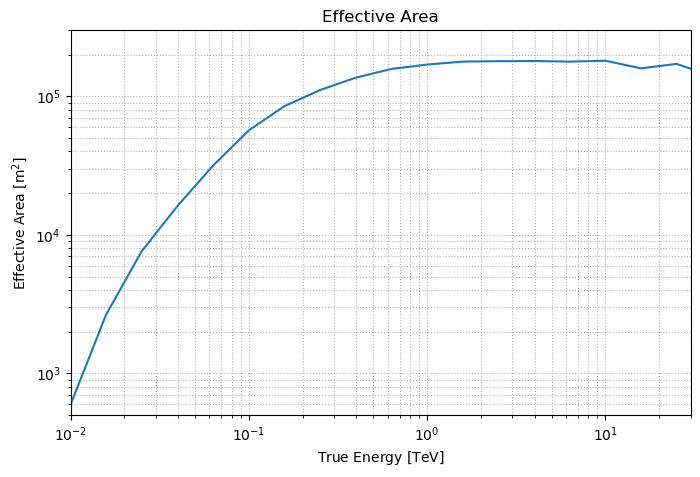

In [88]:
# Effective Area energy dependence
plt.figure(figsize=(8,5))

aeff_plot.plot_energy_dependence(offset=[0.4 * u.deg])
plt.legend().remove()
plt.yscale('log')
plt.grid(which='both', linestyle=":")
plt.xlim(0.01, 30)
plt.ylim(5e2, 3e5)
plt.title("Effective Area")

Text(0.5, 1.0, 'Effective Area - energy offset dependence')

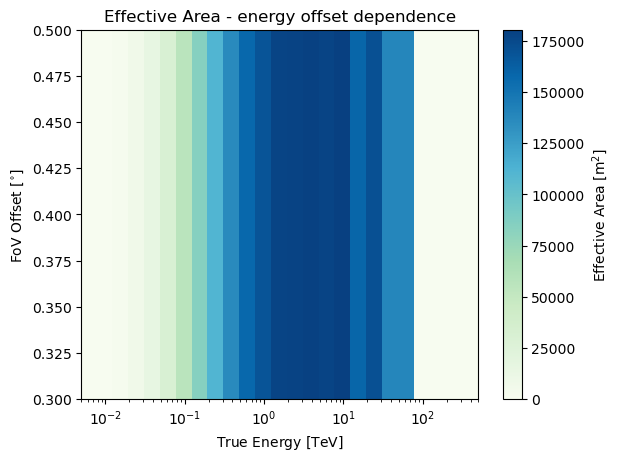

In [77]:
# Energy Offset dependence
aeff_plot.plot()
plt.title("Effective Area - energy offset dependence")

In [78]:
# Effective Area offset dependence when diffuse gamma is used
if not use_point_gamma:
    aeff_plot.plot_offset_dependence()

Text(0.5, 0.98, 'Energy migration')

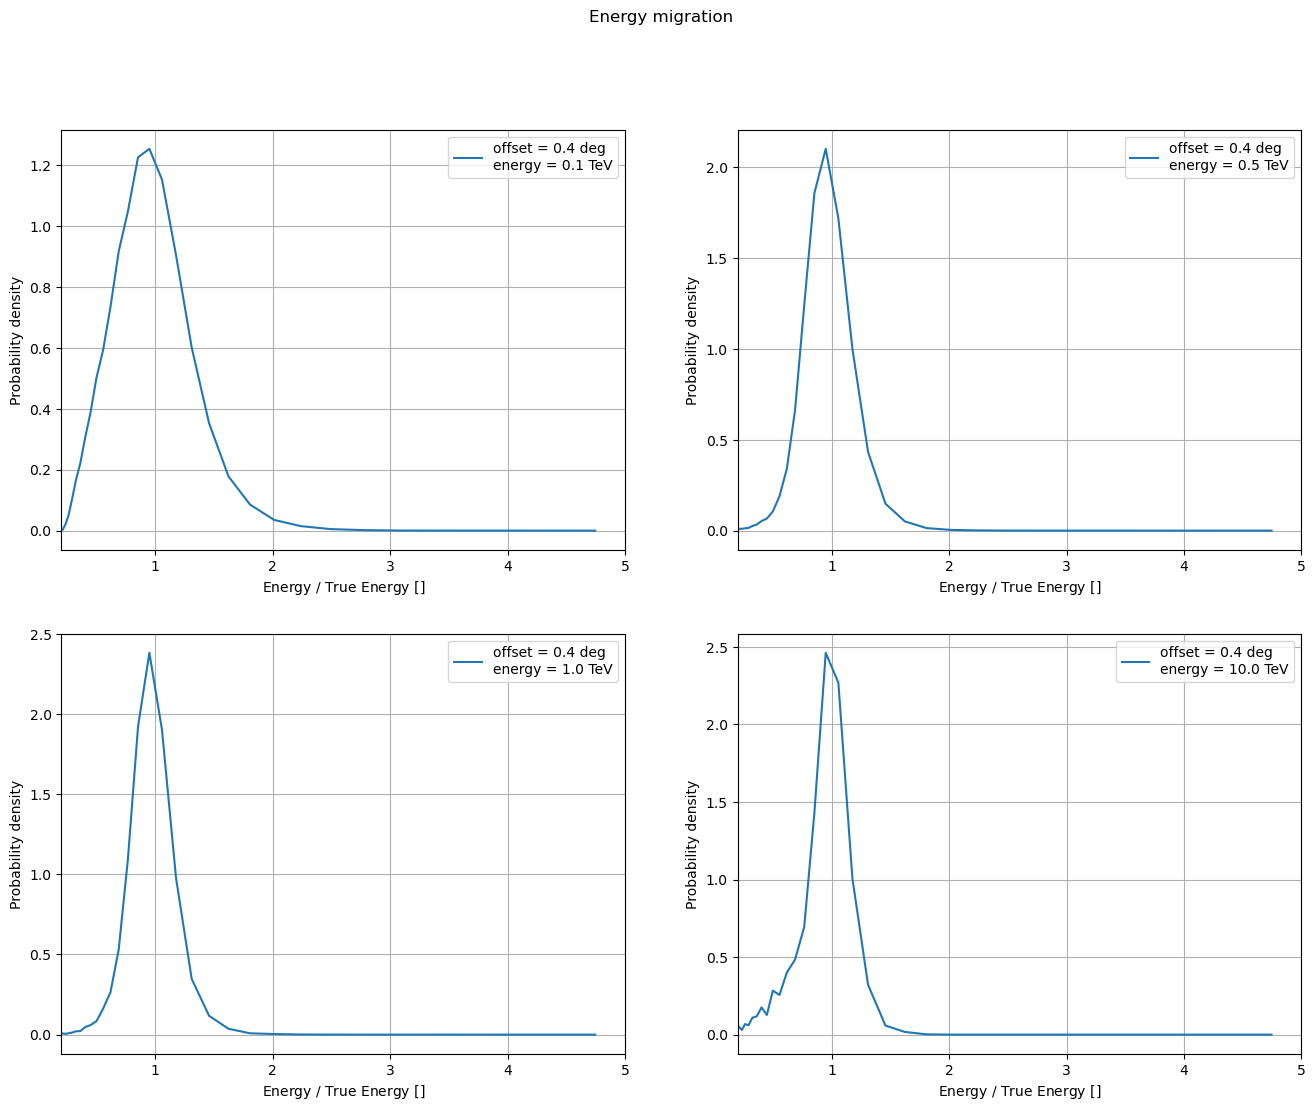

In [79]:
# Energy Dispersion, energy migration
plt.figure(figsize=(16,12))

offset = "0.4 deg"
true_energy = [0.1, 0.5, 1, 10] * u.TeV

plt.subplot(221)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[0])
plt.legend(loc=1)
plt.grid()

plt.subplot(222)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[1])
plt.legend(loc=1)
plt.grid()

plt.subplot(223)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[2])
plt.legend(loc=1)
plt.grid()

plt.subplot(224)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[3])
plt.legend(loc=1)
plt.grid()

plt.suptitle("Energy migration")

Text(0.5, 1.0, 'Energy Bias at 0.4 deg')

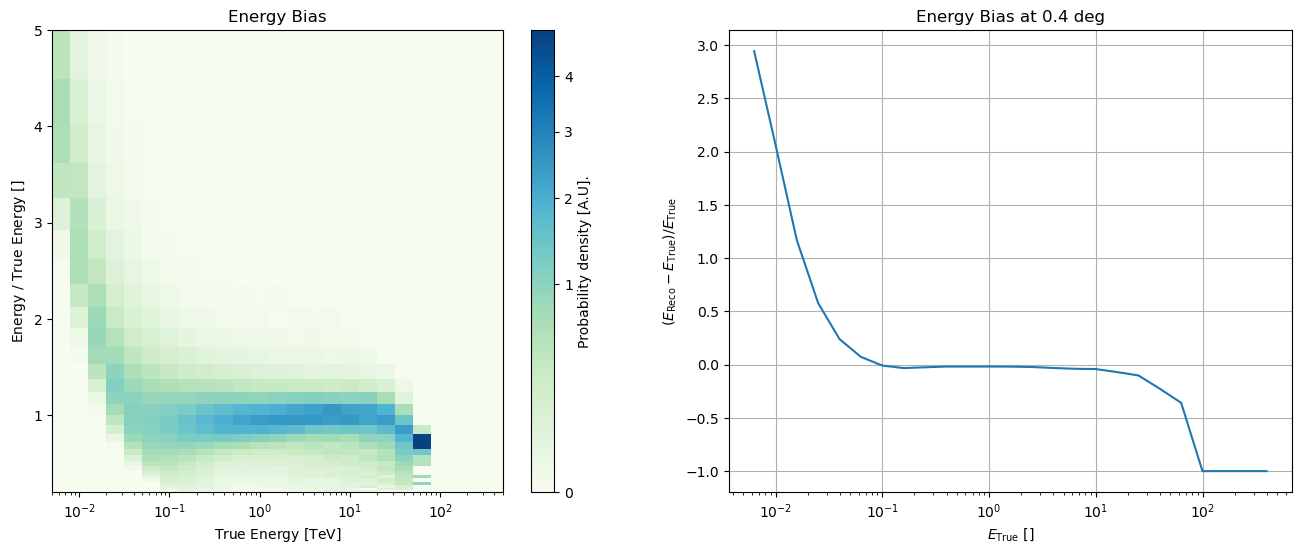

In [80]:
# Energy bias

plt.figure(figsize=(16,6))

plt.subplot(121)
edisp_plot.plot_bias(offset=offset, add_cbar=True)
plt.title("Energy Bias")

plt.subplot(122)
edisp_kernel = edisp_plot.to_edisp_kernel(offset=0.4*u.deg)
edisp_kernel.plot_bias()
plt.grid()
plt.title("Energy Bias at 0.4 deg")

Text(0.5, 1.0, 'Energy Migration Matrix')

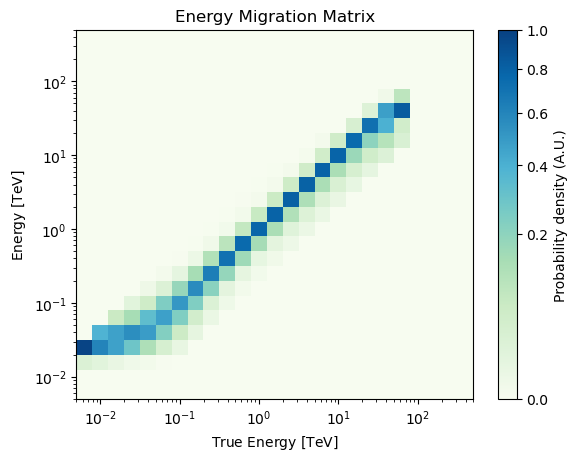

In [81]:
# Energy migration matrix
edisp_kernel.plot_matrix(add_cbar=True)
plt.title("Energy Migration Matrix")

Text(0.5, 1.0, 'Background rate - offset dependence')

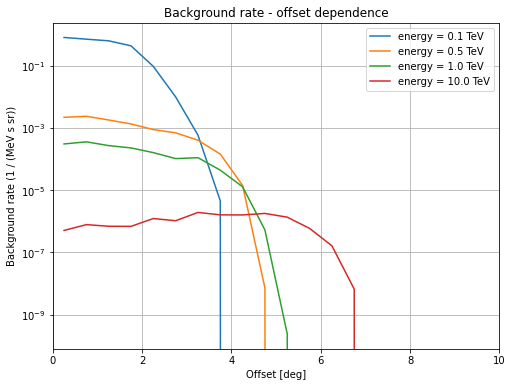

In [14]:
# Background, offset dependence
plt.figure(figsize=(8,6))

bkg_plot.plot_offset_dependence(energy=true_energy)
plt.grid(which="both")
plt.title("Background rate - offset dependence")

Text(0.5, 0.98, 'Background rate - energy dependence')

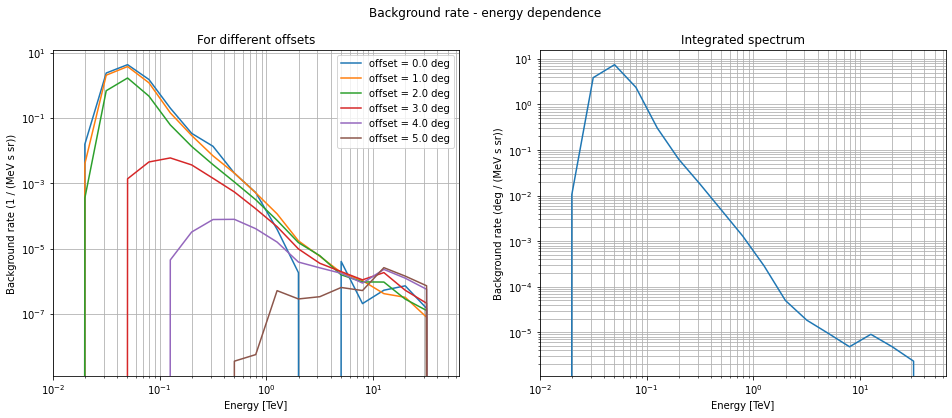

In [15]:
# Background rate energy dependence
plt.figure(figsize=(16,6))
bkg_offset = [0, 1, 2, 3, 4, 5] * u.deg

plt.subplot(121)

labels = []
for o in bkg_offset:
    bkg_plot.plot_energy_dependence(offset=[o])
    labels.append(f"offset = {o}")
plt.legend().remove()
plt.legend(labels)
plt.grid(which="both")
plt.title("For different offsets")

plt.subplot(122)
bkg_plot.plot_spectrum()
plt.grid(which="both")
plt.legend().remove()
plt.title("Integrated spectrum")

plt.suptitle("Background rate - energy dependence")

Text(0.5, 1.0, 'Background rate - energy offset dependence')

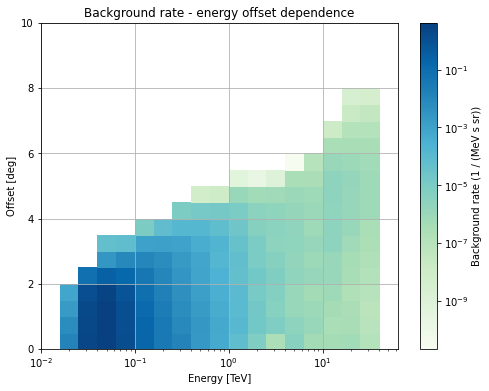

In [16]:
# Energy offset dependence
plt.figure(figsize=(8,6))
bkg_plot.plot()
plt.grid()
plt.title("Background rate - energy offset dependence")

In [82]:
if not point_like:
    psf_plot.peek()

OrderedDict([('CREATOR', 'lstchain v0.10.7.dev16+g7ad812a.d20240129'), ('DATE', '2024-02-06 16:42:33.923'), ('TELESCOP', 'CTA-N'), ('INSTRUME', 'LST-1'), ('FOVALIGN', 'RADEC'), ('ZEN_PNT', 10.0), ('AZ_PNT', 102.199), ('B_TOTAL', 38.592769622802734), ('B_INC', 0.6519277095794678), ('B_DEC', -0.08447393774986267), ('B_DELTA', 50.36070131494917), ('GH_EFF', 0.7), ('TH_CONT', 0.7), ('EXTNAME', 'GH_CUTS')])


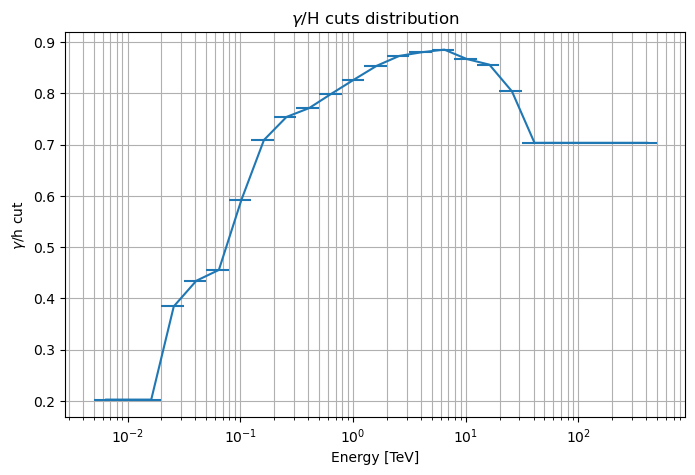

In [89]:
if energy_dependent_gh_cuts:
    print(gh_cut.meta)
    
    plt.figure(figsize=(8,5))
    
    plt.errorbar(
        gh_cut["center"], gh_cut["cut"],
        xerr=(
            gh_cut["center"] - gh_cut["low"], 
            gh_cut["high"] - gh_cut["center"]
        )
    )

    plt.xscale('log')
    plt.title(r"$\gamma$/H cuts distribution")
    plt.ylabel(r'$\gamma$/h cut')
    plt.xlabel('Energy [TeV]')
    plt.grid(which='both')

OrderedDict([('CREATOR', 'pyirf v0.10.1'), ('HDUDOC', 'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'), ('HDUVERS', '0.2'), ('HDUCLASS', 'GADF'), ('HDUCLAS1', 'RESPONSE'), ('HDUCLAS2', 'RAD_MAX'), ('HDUCLAS3', 'POINT-LIKE'), ('HDUCLAS4', 'RAD_MAX_2D'), ('DATE', '2024-02-06 16:42:33.933'), ('TELESCOP', 'CTA-N'), ('INSTRUME', 'LST-1'), ('FOVALIGN', 'RADEC'), ('ZEN_PNT', 10.0), ('AZ_PNT', 102.199), ('B_TOTAL', 38.592769622802734), ('B_INC', 0.6519277095794678), ('B_DEC', -0.08447393774986267), ('B_DELTA', 50.36070131494917), ('GH_EFF', 0.7), ('TH_CONT', 0.7), ('EXTNAME', 'RAD_MAX')])


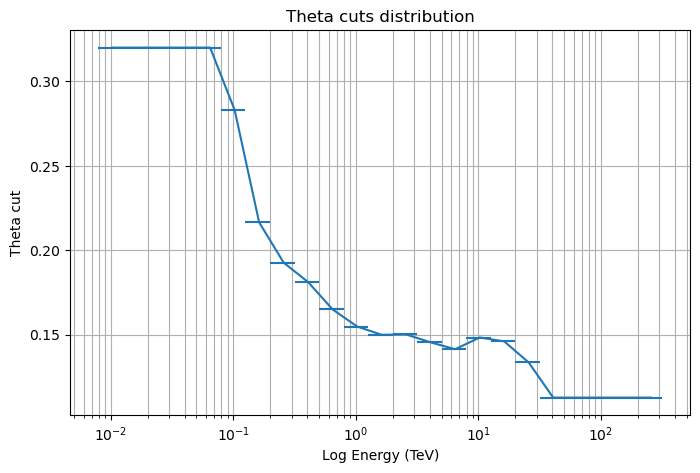

In [84]:
if energy_dependent_theta_cuts:
    print(theta_cut.meta)
    
    plt.figure(figsize=(8,5))
    plt.errorbar(
        0.5 * (theta_cut[0]['ENERG_LO'] + theta_cut[0]['ENERG_HI'])[1:-1],
        theta_cut[0]['RAD_MAX'].T[1:-1, 0],
        xerr=0.5 * (theta_cut[0]['ENERG_HI'] - theta_cut[0]['ENERG_LO'])[1:-1]
    )
    plt.xscale('log')
    plt.title("Theta cuts distribution")
    plt.ylabel('Theta cut')
    plt.xlabel('Log Energy (TeV)')
    plt.grid(which='both')